In [2]:
library("repr")
library("tidyverse")
install.packages('cowplot')
library('cowplot')
library('colorspace')

# Sets the default size of the figures in the notebook
options(repr.plot.width=12.7, repr.plot.height=8.5)

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)


Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [3]:
genome_data = read_csv(url('https://raw.githubusercontent.com/btemperton/BIO3097/main/full-genome-data.csv'), show_col_types = FALSE, col_type='ccddicf')
head(genome_data)

organism_name,taxonomy,size_mb,gc,num_genes,host,type
<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<fct>
Intestinibacter bartlettii,Bacteria;Terrabacteria group;Bacillota,3.00627,29.1000,2644,Homo sapiens,prokaryote
Burkholderia glumae,Bacteria;Pseudomonadota;Betaproteobacteria,7.32842,67.9114,6340,plants,prokaryote
Priestia megaterium,Bacteria;Terrabacteria group;Bacillota,5.17185,38.3000,5158,NA,prokaryote
Brucella melitensis,Bacteria;Pseudomonadota;Alphaproteobacteria,3.31189,57.2358,2971,none,prokaryote
Lacticaseibacillus rhamnosus,Bacteria;Terrabacteria group;Bacillota,2.99119,46.8000,2649,Homo sapiens,prokaryote
Pasteurella multocida,Bacteria;Pseudomonadota;Gammaproteobacteria,2.49599,40.3000,2355,rabbit,prokaryote


## The tidyverse 'pipe' - `%>%`

Tidyverse allows you to manipulate dataframes in hundreds of different ways by combining different methods together. It does this using the 'pipe' operator - `%>%`. What this means is 'take the dataframe that is to the left of this operator, and use it as the input to the function on the right of this operator.

For instance, if we wanted to filter out just the prokaryotes in the dataframe above into a new dataframe, we would use the `filter` method and do something like:



In [4]:
prokaryotes_only = genome_data %>% filter(type=='prokaryote')
summary(prokaryotes_only)

 organism_name        taxonomy            size_mb              gc       
 Length:35553       Length:35553       Min.   : 0.1002   Min.   : 0.00  
 Class :character   Class :character   1st Qu.: 2.7874   1st Qu.:38.90  
 Mode  :character   Mode  :character   Median : 4.3006   Median :50.69  
                                       Mean   : 4.1821   Mean   :49.37  
                                       3rd Qu.: 5.2923   3rd Qu.:59.40  
                                       Max.   :16.0407   Max.   :76.20  
   num_genes         host                   type      
 Min.   :   39   Length:35553       prokaryote:35553  
 1st Qu.: 2548   Class :character   phage     :    0  
 Median : 3855   Mode  :character                     
 Mean   : 3757                                        
 3rd Qu.: 4804                                        
 Max.   :14561                                        

in the `filter` method, we are testing each row to see if the `type` column has a value equal to (`==`) the word `prokaryote`. Note the use of double `==` here, which is a test to see if the left value is equal in value to the right value.

A single `=` sign in R, (as seen in `genome_data = read_csv...`) means `assign the value of the right hand side to the name given on the left hand side`

You'll notice in the above that some of our GC content is 0. That seems weird - no genomes use ONLY A and T bases, so it is most likely an error in the data. We can remove these rows by adding a second filter to test that this value is greater than 0. This is the first example of how we can **chain together** tidyverse commands to slice the data how we want.

In [5]:
prokaryotes_only = genome_data %>% filter(type=='prokaryote') %>% filter(gc > 0)
summary(prokaryotes_only)

 organism_name        taxonomy            size_mb              gc       
 Length:35259       Length:35259       Min.   : 0.1002   Min.   :13.50  
 Class :character   Class :character   1st Qu.: 2.7881   1st Qu.:38.99  
 Mode  :character   Mode  :character   Median : 4.3012   Median :50.70  
                                       Mean   : 4.1826   Mean   :49.78  
                                       3rd Qu.: 5.2950   3rd Qu.:59.50  
                                       Max.   :16.0407   Max.   :76.20  
   num_genes         host                   type      
 Min.   :   39   Length:35259       prokaryote:35259  
 1st Qu.: 2550   Class :character   phage     :    0  
 Median : 3856   Mode  :character                     
 Mean   : 3758                                        
 3rd Qu.: 4807                                        
 Max.   :14561                                        

Now let's say we wanted to pull out any prokaryotes that were NOT either pathogens or obligate parasites. i.e. these will have no associated host data. Here, we want to pull out any records where the value of host is NA (not available). Values of `NA` are a special value in R, and so there is a special function to test for them called `is.na`. We'll save this in a variable called `free_living`

In [8]:
free_living = genome_data %>% filter(type=='prokaryote') %>% filter(gc > 0) %>% filter(is.na(host))
summary(free_living)

 organism_name        taxonomy            size_mb              gc       
 Length:10179       Length:10179       Min.   : 0.1384   Min.   :17.80  
 Class :character   Class :character   1st Qu.: 3.1458   1st Qu.:42.36  
 Mode  :character   Mode  :character   Median : 4.1951   Median :52.20  
                                       Mean   : 4.4274   Mean   :52.29  
                                       3rd Qu.: 5.4503   3rd Qu.:63.26  
                                       Max.   :16.0407   Max.   :76.20  
   num_genes         host                   type      
 Min.   :  116   Length:10179       prokaryote:10179  
 1st Qu.: 2832   Class :character   phage     :    0  
 Median : 3841   Mode  :character                     
 Mean   : 3956                                        
 3rd Qu.: 4878                                        
 Max.   :14018                                        

Now let's say we wanted to pull out all the Pelagibacter genomes. We can search the `organism_name` for the correct word. This uses a pattern match known as a regular expression, or `regex`. They can be quite complicated, so for now let's just stick to matching single words.

In [16]:
pelagibacters = genome_data %>% filter(type=='prokaryote') %>% filter(gc > 0) %>% filter(is.na(host)) %>% filter(grepl('Pelagibacter', organism_name, ignore.case=TRUE))
pelagibacters

organism_name,taxonomy,size_mb,gc,num_genes,host,type
<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<fct>
Candidatus Pelagibacter sp. IMCC9063,Bacteria;Pseudomonadota;Alphaproteobacteria,1.28473,31.7000,1382,NA,prokaryote
Pelagibacterium halotolerans B2,Bacteria;Pseudomonadota;Alphaproteobacteria,3.94889,61.3946,3768,NA,prokaryote
Candidatus Pelagibacter ubique HTCC1062,Bacteria;Pseudomonadota;Alphaproteobacteria,1.30876,29.7000,1338,NA,prokaryote
Pelagibacterium halotolerans,Bacteria;Pseudomonadota;Alphaproteobacteria,3.96230,61.4000,3778,NA,prokaryote
Candidatus Pelagibacter sp. FZCC0015,Bacteria;Pseudomonadota;Alphaproteobacteria,1.36410,29.2000,1429,NA,prokaryote
Pelagibacterium sp. YIM 151497,Bacteria;Pseudomonadota;Alphaproteobacteria,3.93046,60.7000,3809,NA,prokaryote
Candidatus Pelagibacter giovannonii,Bacteria;Pseudomonadota;Alphaproteobacteria,1.36570,29.5000,1445,NA,prokaryote


You will note that this includes both `Pelagibacter` and `Pelagibacterium`. Both of these match the search criteria, but they are two different species. `Pelagibacterium` is not a streamlined organism and has genomes of ~ 3.9 Mb.

So, we can adapt our search by adding `Candidatus Pelagibacter` to the search.

In [56]:
pelagibacters = genome_data %>% filter(type=='prokaryote') %>% filter(gc > 0) %>% filter(is.na(host)) %>% filter(grepl('Candidatus Pelagibacter', organism_name, ignore.case=TRUE))
pelagibacters

organism_name,taxonomy,size_mb,gc,num_genes,host,type
<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<fct>
Candidatus Pelagibacter sp. IMCC9063,Bacteria;Pseudomonadota;Alphaproteobacteria,1.28473,31.7,1382,NA,prokaryote
Candidatus Pelagibacter ubique HTCC1062,Bacteria;Pseudomonadota;Alphaproteobacteria,1.30876,29.7,1338,NA,prokaryote
Candidatus Pelagibacter sp. FZCC0015,Bacteria;Pseudomonadota;Alphaproteobacteria,1.36410,29.2,1429,NA,prokaryote
Candidatus Pelagibacter giovannonii,Bacteria;Pseudomonadota;Alphaproteobacteria,1.36570,29.5,1445,NA,prokaryote


If we wanted to make a dataframe of Pelagibacters and Prochlorococcus, we could make two separate dataframes and then combine them with `bind_rows`, which will concatenate two dataframes together as long as the column names are the same (which they will be in this case)

In [57]:
pelagibacters = genome_data %>% filter(type=='prokaryote') %>% filter(gc > 0) %>% filter(is.na(host)) %>% filter(grepl('Candidatus Pelagibacter', organism_name, ignore.case=TRUE))
prochlorococcus = genome_data %>% filter(type=='prokaryote') %>% filter(gc > 0) %>% filter(is.na(host)) %>% filter(grepl('Prochlorococcus', organism_name, ignore.case=TRUE))
combined_dataframe = pelagibacters %>% bind_rows(prochlorococcus)
combined_dataframe

organism_name,taxonomy,size_mb,gc,num_genes,host,type
<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<fct>
Candidatus Pelagibacter sp. IMCC9063,Bacteria;Pseudomonadota;Alphaproteobacteria,1.28473,31.7,1382,NA,prokaryote
Candidatus Pelagibacter ubique HTCC1062,Bacteria;Pseudomonadota;Alphaproteobacteria,1.30876,29.7,1338,NA,prokaryote
Candidatus Pelagibacter sp. FZCC0015,Bacteria;Pseudomonadota;Alphaproteobacteria,1.36410,29.2,1429,NA,prokaryote
Candidatus Pelagibacter giovannonii,Bacteria;Pseudomonadota;Alphaproteobacteria,1.36570,29.5,1445,NA,prokaryote
Prochlorococcus marinus str. MIT 0919,Bacteria;Terrabacteria group;Cyanobacteriota/Melainabacteria group,1.71677,37.0,1820,NA,prokaryote
Prochlorococcus marinus str. MIT 9312,Bacteria;Terrabacteria group;Cyanobacteriota/Melainabacteria group,1.70920,31.2,1859,NA,prokaryote
Prochlorococcus marinus str. AS9601,Bacteria;Terrabacteria group;Cyanobacteriota/Melainabacteria group,1.66989,31.3,1837,NA,prokaryote
Prochlorococcus marinus str. MIT 9301,Bacteria;Terrabacteria group;Cyanobacteriota/Melainabacteria group,1.64188,31.3,1838,NA,prokaryote
Prochlorococcus marinus str. MIT 9313,Bacteria;Terrabacteria group;Cyanobacteriota/Melainabacteria group,2.41087,50.7,2355,NA,prokaryote


# Adding new columns

Let's say we want to calculate *coding density*, i.e. the number of genes encoded per MB of genome. We can create a new column using the `mutate` function and provide it with the name of the column (`coding_density`) and how to calculate it from other columns in the data:

In [58]:
genome_data_new = genome_data %>% mutate(coding_density=num_genes/size_mb)
head(genome_data_new)

organism_name,taxonomy,size_mb,gc,num_genes,host,type,coding_density
<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<fct>,<dbl>
Intestinibacter bartlettii,Bacteria;Terrabacteria group;Bacillota,3.00627,29.1000,2644,Homo sapiens,prokaryote,879.4952
Burkholderia glumae,Bacteria;Pseudomonadota;Betaproteobacteria,7.32842,67.9114,6340,plants,prokaryote,865.1251
Priestia megaterium,Bacteria;Terrabacteria group;Bacillota,5.17185,38.3000,5158,NA,prokaryote,997.3220
Brucella melitensis,Bacteria;Pseudomonadota;Alphaproteobacteria,3.31189,57.2358,2971,none,prokaryote,897.0709
Lacticaseibacillus rhamnosus,Bacteria;Terrabacteria group;Bacillota,2.99119,46.8000,2649,Homo sapiens,prokaryote,885.6007
Pasteurella multocida,Bacteria;Pseudomonadota;Gammaproteobacteria,2.49599,40.3000,2355,rabbit,prokaryote,943.5134


`mutate` can get really powerful when you combine it with the `ifelse` function. Let's say we want to make a plot of genome size vs number of genes as we did in the previous notebook, but we want to just highlight the pelagibacters and the prochlororoccus genomes in different colours. We want the rest to be grey.

For this, we need a new factor on the table so that we can tell `ggplot` how to colour the points. We'll call it `highlight` and it'll be a factor with three values: `Pelagibacter`, `Prochlorococcus`, and `Other`

Step one will be to just pull out the free living prokaryotes as we did above:

In [59]:
prokaryotes_only = genome_data %>% filter(type=='prokaryote') %>% filter(gc > 0)
head(prokaryotes_only)

organism_name,taxonomy,size_mb,gc,num_genes,host,type
<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<fct>
Intestinibacter bartlettii,Bacteria;Terrabacteria group;Bacillota,3.00627,29.1000,2644,Homo sapiens,prokaryote
Burkholderia glumae,Bacteria;Pseudomonadota;Betaproteobacteria,7.32842,67.9114,6340,plants,prokaryote
Priestia megaterium,Bacteria;Terrabacteria group;Bacillota,5.17185,38.3000,5158,NA,prokaryote
Brucella melitensis,Bacteria;Pseudomonadota;Alphaproteobacteria,3.31189,57.2358,2971,none,prokaryote
Lacticaseibacillus rhamnosus,Bacteria;Terrabacteria group;Bacillota,2.99119,46.8000,2649,Homo sapiens,prokaryote
Pasteurella multocida,Bacteria;Pseudomonadota;Gammaproteobacteria,2.49599,40.3000,2355,rabbit,prokaryote


Step 2 will be to add a new column called `highlight` and give it the default value of `Other` (we'll change this for Pelagibacter and Prochlorococcus in a minute).

In [60]:
prokaryotes_only = genome_data %>% filter(type=='prokaryote') %>% filter(gc > 0) %>% mutate(highlight='Other')
head(prokaryotes_only)

organism_name,taxonomy,size_mb,gc,num_genes,host,type,highlight
<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<fct>,<chr>
Intestinibacter bartlettii,Bacteria;Terrabacteria group;Bacillota,3.00627,29.1000,2644,Homo sapiens,prokaryote,Other
Burkholderia glumae,Bacteria;Pseudomonadota;Betaproteobacteria,7.32842,67.9114,6340,plants,prokaryote,Other
Priestia megaterium,Bacteria;Terrabacteria group;Bacillota,5.17185,38.3000,5158,NA,prokaryote,Other
Brucella melitensis,Bacteria;Pseudomonadota;Alphaproteobacteria,3.31189,57.2358,2971,none,prokaryote,Other
Lacticaseibacillus rhamnosus,Bacteria;Terrabacteria group;Bacillota,2.99119,46.8000,2649,Homo sapiens,prokaryote,Other
Pasteurella multocida,Bacteria;Pseudomonadota;Gammaproteobacteria,2.49599,40.3000,2355,rabbit,prokaryote,Other


Now, you might start to notice that the pipes can get a bit long. To make it clearer to read, you can put anything AFTER the pipe operator on a new line:

In [62]:
prokaryotes_only = genome_data %>%
  filter(type=='prokaryote') %>%
    filter(gc > 0) %>%
      mutate(highlight='Other')

table(prokaryotes_only$highlight)


Other 
35259 


The `table` command used here simply counts the number of occurences of each value in a column. Here, all rows have a `highlight` value of `Other`.

Let's now change the values for Pelagibacters using `ifelse`. `ifelse` works by passing it a test to carry out (in this case if the `organism_name` includes the word `Pelagibacter` as we did above), and then a value to assign if it is true, and then a value to assign if it is false.

Here, we will assign the value of 'Pelagibacter' to `highlight` if the `organism_name` has `Pelagibacter` in it, and set it to the current value of `highlight` (e.g. 'Other') if it does not. Note, in the second `mutate` we are effectively writing over the top of the `highlight` column with the new value.

In [63]:
prokaryotes_only = genome_data %>%
  filter(type=='prokaryote') %>%
    filter(gc > 0) %>%
      mutate(highlight='Other') %>%
        mutate(highlight=ifelse(grepl('Candidatus Pelagibacter', organism_name, ignore.case=TRUE), 'Pelagibacter', highlight))
table(prokaryotes_only$highlight)


       Other Pelagibacter 
       35255            4 

We can do the same for Prochlorococcus

In [64]:
prokaryotes_only = genome_data %>%
  filter(type=='prokaryote') %>%
    filter(gc > 0) %>%
      mutate(highlight='Other') %>%
        mutate(highlight=ifelse(grepl('Candidatus Pelagibacter', organism_name, ignore.case=TRUE), 'Pelagibacter', highlight)) %>%
        mutate(highlight=ifelse(grepl('Prochlorococcus', organism_name, ignore.case=TRUE), 'Prochlorococcus', highlight))
table(prokaryotes_only$highlight)


          Other    Pelagibacter Prochlorococcus 
          35234               4              21 

Now we have everything we need to make our cool plot, by using `highlight` as the factor for the `fill` and the `color` parameters in the `geom_point` aesthetic

`geom_smooth()` using formula = 'y ~ x'


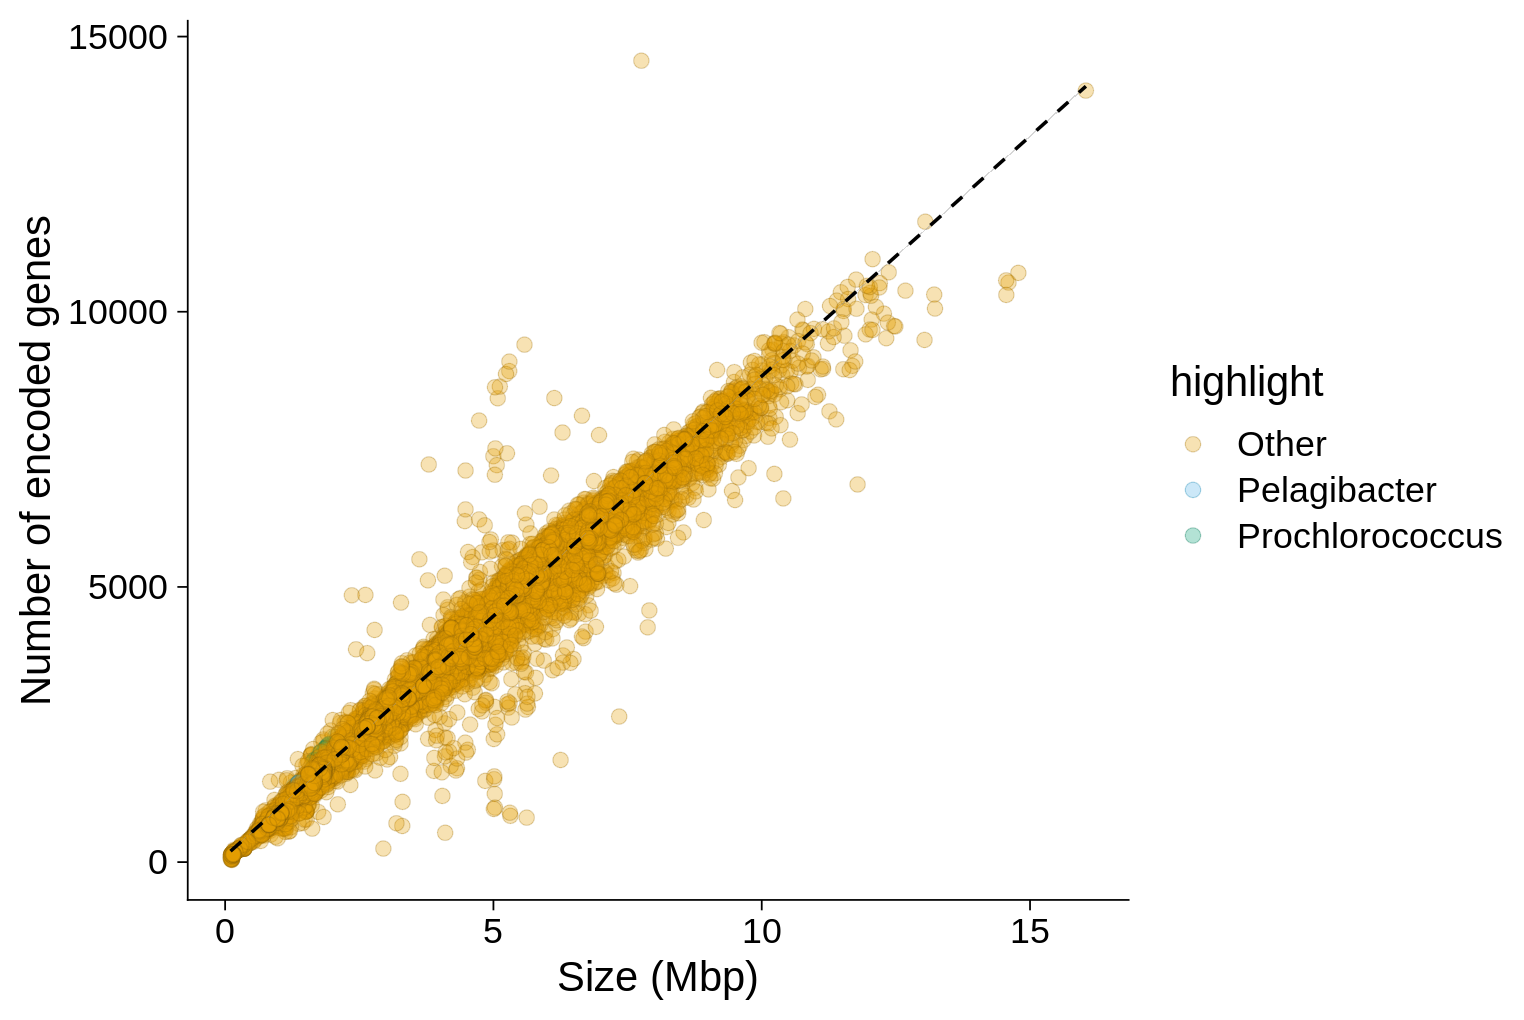

In [65]:
okabe_ito <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#999999")


ggplot(prokaryotes_only, aes(x=size_mb, y=num_genes)) +
  geom_point(aes(color = highlight, fill = highlight),
             size=4, shape=21, alpha=0.3) +
  scale_x_continuous(name='Size (Mbp)') +
  scale_y_continuous(name='Number of encoded genes') +
  scale_fill_manual(values=okabe_ito) +
  scale_color_manual(values=darken(okabe_ito, 0.3)) +
  geom_smooth(method='lm', colour='black', linetype='dashed') +
  theme_cowplot(25)

Oh dear. It looks like our interesting species are hidden amongst the others. We can get round this by changing the shape, size and alpha of the `geom_point` to vary depending on the value of `highlight`. To do this we need to add it to the `aes` of `geom_point`. We can then scale each of these manually by adding the correct `scale_shape_manual` and `scale_size_manual` functions.

`geom_smooth()` using formula = 'y ~ x'


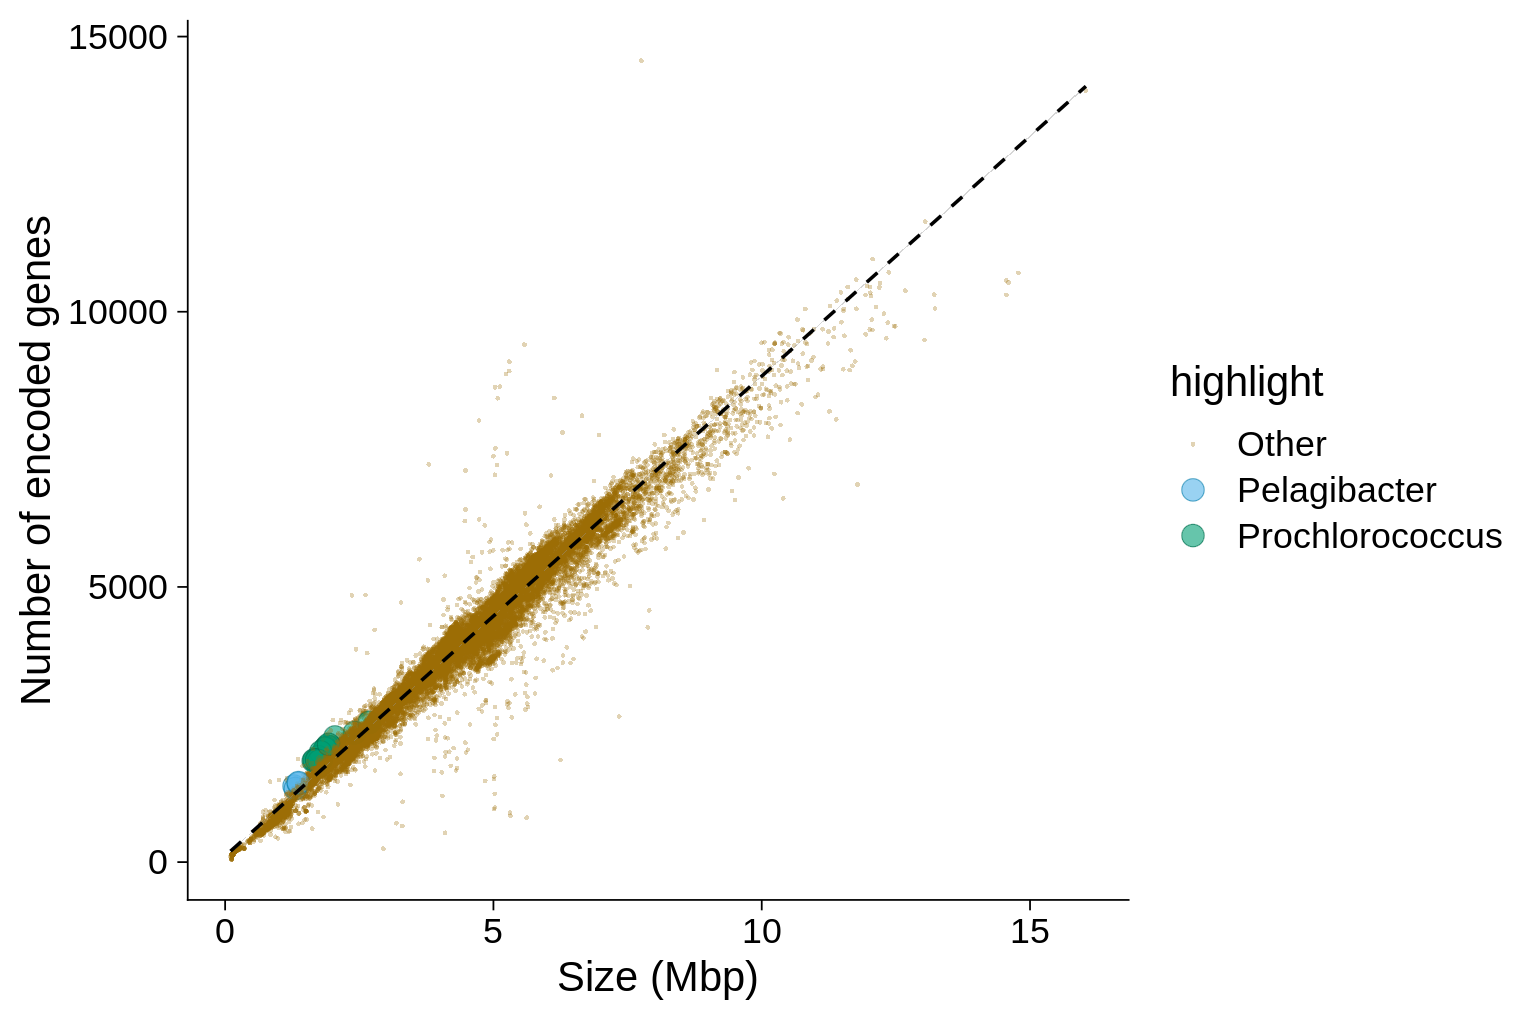

In [66]:
okabe_ito <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#999999")


ggplot(prokaryotes_only, aes(x=size_mb, y=num_genes)) +
  geom_point(aes(color = highlight, fill = highlight, shape=highlight, size=highlight, alpha=highlight)) +
  scale_x_continuous(name='Size (Mbp)') +
  scale_y_continuous(name='Number of encoded genes') +
  scale_fill_manual(values=okabe_ito) +
  scale_color_manual(values=darken(okabe_ito, 0.3)) +
  scale_shape_manual(values = c(16,21,21)) +
  scale_size_manual(values=c(1,6,6)) +
  scale_alpha_manual(values=c(0.3, 0.6, 0.6)) +
  geom_smooth(method='lm', colour='black', linetype='dashed') +
  theme_cowplot(25)

I mean it's better, but still not very clear. Here we can leverage the power of `ggplot` to plot multiple datasets on the same graph. We will divide up the three `highlight` types, and plot `Other` first, then the two remaining categories. Note, we can include the pipe operator in our ggplot to do the filtering!

Note, if we want the `geom_smooth` to use all the data, we need to specify the full dataset, otherwise it'll use what's in the earliest call to `ggplot` (in this case `prokaryotes_only %>% filter(highlight=='Other')`

`geom_smooth()` using formula = 'y ~ x'


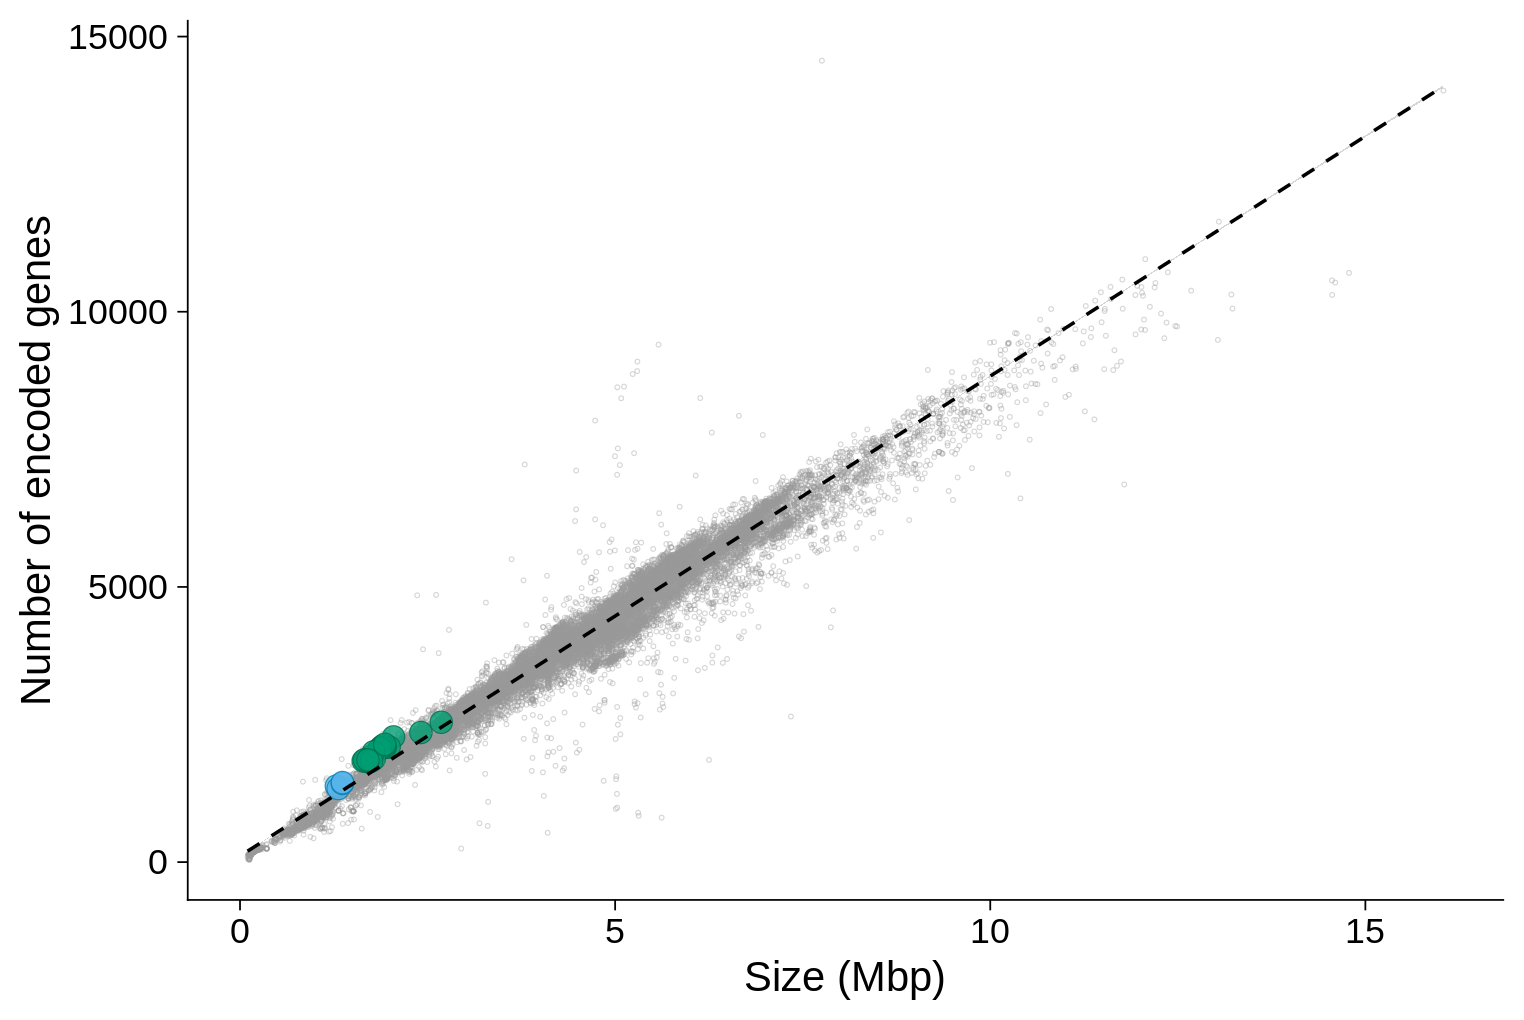

In [67]:


ggplot(prokaryotes_only %>% filter(highlight=='Other'), aes(x=size_mb, y=num_genes)) +
  geom_point(color="#999999", shape=1, size=1, fill="#999999", alpha=0.4) +
  geom_point(data=prokaryotes_only %>% filter(highlight=='Pelagibacter'), color=darken("#56B4E9", 0.3), shape=21, size=6, fill="#56B4E9", alpha=0.8) +
  geom_point(data=prokaryotes_only %>% filter(highlight=='Prochlorococcus'), color=darken("#009E73", 0.3), shape=21, size=6, fill="#009E73", alpha=0.8) +
  scale_x_continuous(name='Size (Mbp)') +
  scale_y_continuous(name='Number of encoded genes') +
  geom_smooth(data=prokaryotes_only, method='lm', colour='black', linetype='dashed') +
  theme_cowplot(25)

You can see in this graph just how small these genomes are compared to other free living bacteria!

# Other types of plot

We now have categorical data that explains genome size and encoding genes. What if we wanted to compare `coding_density` between Pelagibacter Prochlorococcus and other bacteria? We can start to use the other types of `geom_` available in `ggplot`. For instance if we wanted to do a barplot, we would set the x axis to be the categorical variable `highlight` and the y axis to be `coding_density`.

Because we want to use `highlight` as a categorical variable, we'll need to convert it into a factor using `mutate` and specify its levels. The order in which you specify the names determines the order they appear on the x-axis.

In [72]:
prokaryotes_only = genome_data %>%
  filter(type=='prokaryote') %>%
    filter(gc > 0) %>%
      mutate(highlight='Other') %>%
        mutate(highlight=ifelse(grepl('Candidatus Pelagibacter', organism_name, ignore.case=TRUE), 'Pelagibacter', highlight)) %>%
        mutate(highlight=ifelse(grepl('Prochlorococcus', organism_name, ignore.case=TRUE), 'Prochlorococcus', highlight)) %>%
        mutate(coding_density=num_genes/size_mb) %>%
        mutate(highlight=factor(highlight, levels=c('Pelagibacter', 'Prochlorococcus', 'Other')))

head(prokaryotes_only)





organism_name,taxonomy,size_mb,gc,num_genes,host,type,highlight,coding_density
<chr>,<chr>,<dbl>,<dbl>,<int>,<chr>,<fct>,<fct>,<dbl>
Intestinibacter bartlettii,Bacteria;Terrabacteria group;Bacillota,3.00627,29.1000,2644,Homo sapiens,prokaryote,Other,879.4952
Burkholderia glumae,Bacteria;Pseudomonadota;Betaproteobacteria,7.32842,67.9114,6340,plants,prokaryote,Other,865.1251
Priestia megaterium,Bacteria;Terrabacteria group;Bacillota,5.17185,38.3000,5158,NA,prokaryote,Other,997.3220
Brucella melitensis,Bacteria;Pseudomonadota;Alphaproteobacteria,3.31189,57.2358,2971,none,prokaryote,Other,897.0709
Lacticaseibacillus rhamnosus,Bacteria;Terrabacteria group;Bacillota,2.99119,46.8000,2649,Homo sapiens,prokaryote,Other,885.6007
Pasteurella multocida,Bacteria;Pseudomonadota;Gammaproteobacteria,2.49599,40.3000,2355,rabbit,prokaryote,Other,943.5134


Now let's plot a bar plot with the mean value as the y-axis value.

No summary function supplied, defaulting to `mean_se()`


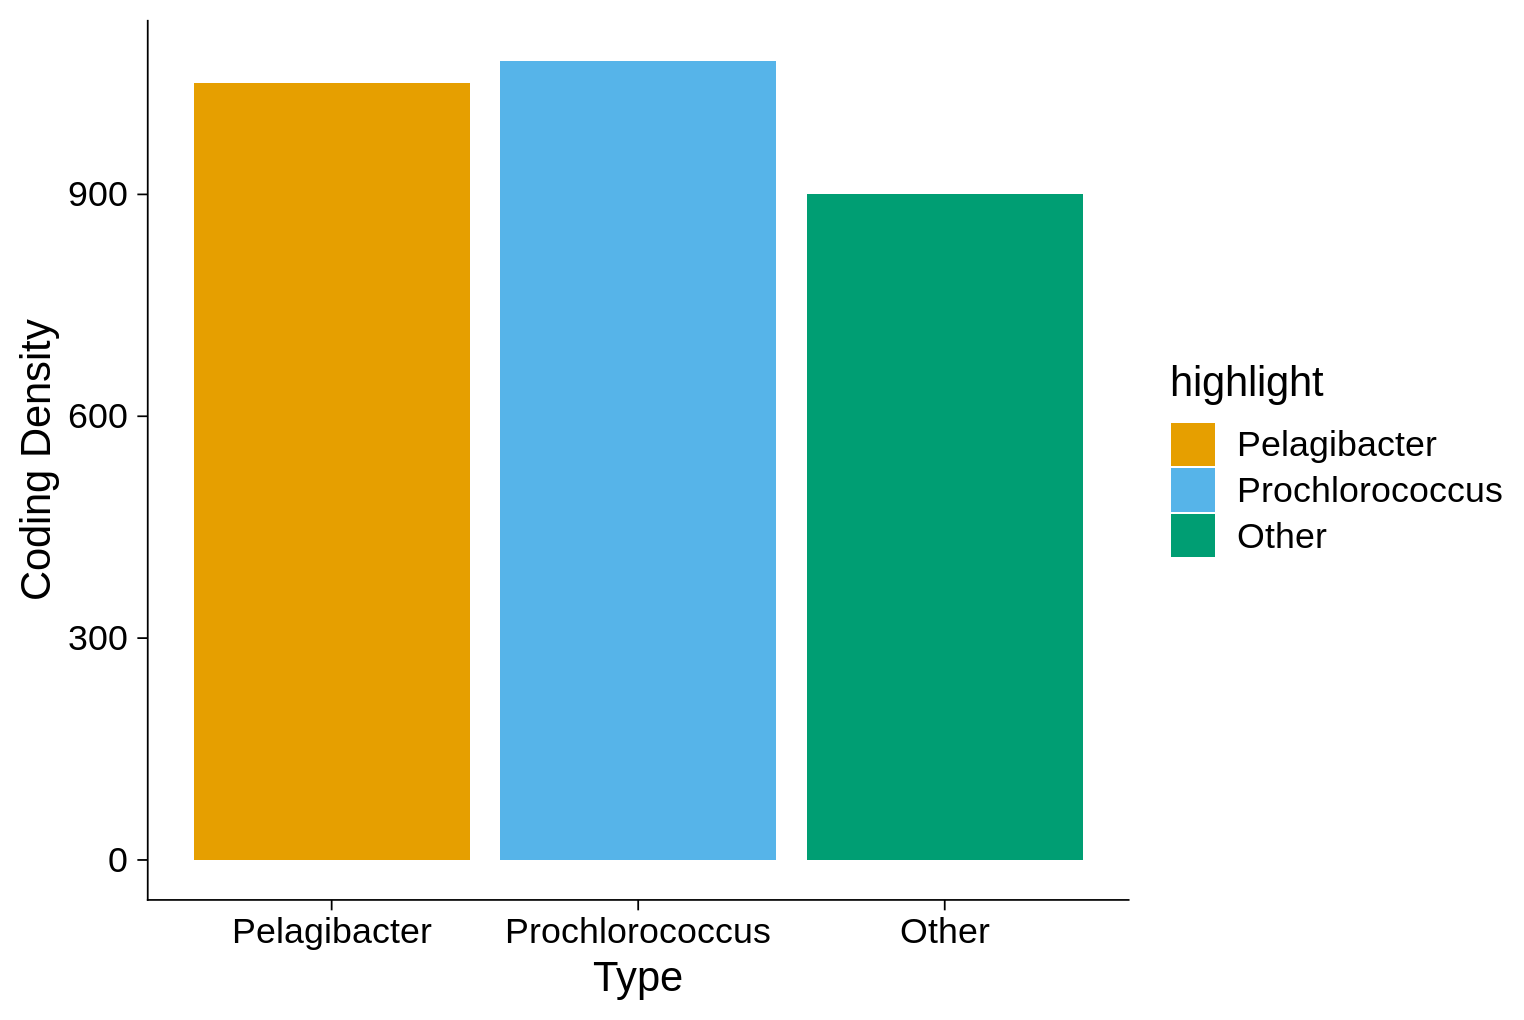

In [78]:
okabe_ito <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#999999")


ggplot(prokaryotes_only, aes(x=highlight, y=coding_density)) +
  geom_bar(aes(fill=highlight), stat = "summary") +
  scale_x_discrete(name='Type') +
  scale_y_continuous(name='Coding Density') +
  scale_fill_manual(values=okabe_ito) +
  theme_cowplot(25)

You can see that Pelagibacter and Prochlorococccus have higher mean coding density than other genomes.

But all the information associated with the underlying distributions of the data (i.e. what is actually in the data) is missing. Our data has been reduced to a single value (the mean). This is bad.

Boxplots are a much better choice for this kind of data as they capture the distribution of the underlying data. In `ggplot` it's a simple case of just swapping out the plot aesthetic from `geom_bar` to `geom_boxplot`

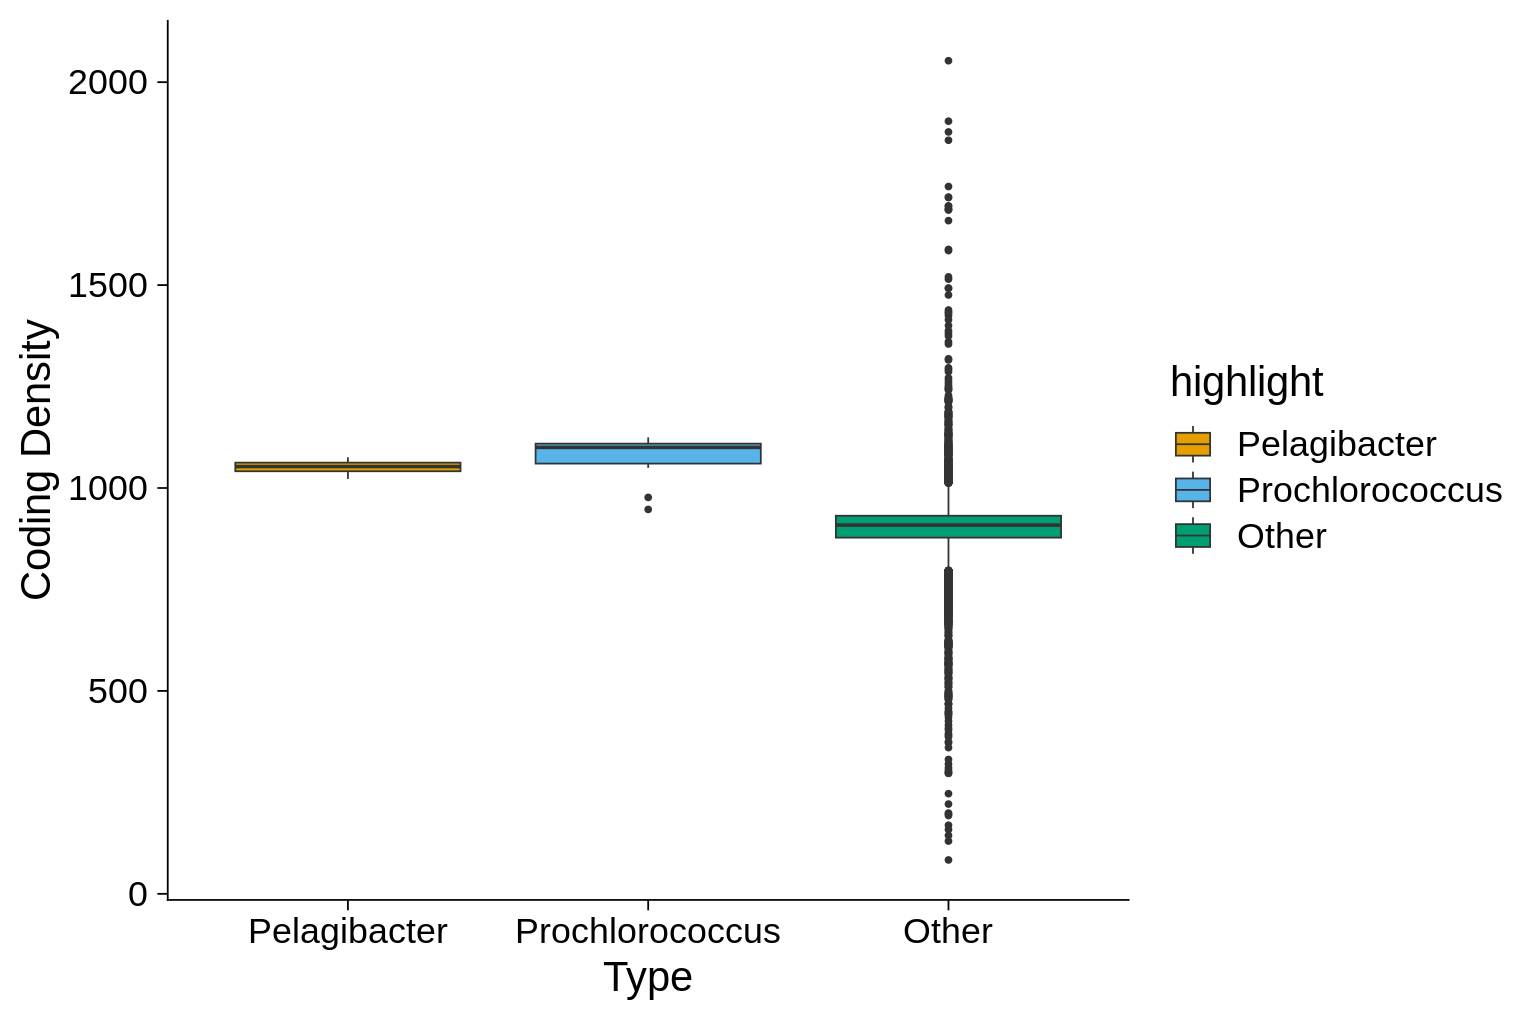

In [81]:
okabe_ito <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#999999")


ggplot(prokaryotes_only, aes(x=highlight, y=coding_density)) +
  geom_boxplot(aes(fill=highlight)) +
  scale_x_discrete(name='Type') +
  scale_y_continuous(name='Coding Density') +
  scale_fill_manual(values=okabe_ito) +
  theme_cowplot(25)

Those are some CRUSHED boxplots, because the variability of `Other` is so big compared to those of the other two categories. We can resolve this by limitng the y-axis to values between 800 and 1200 in the `scale_y_continuous` function.

Warning message:
“Removed 1853 rows containing non-finite values (`stat_boxplot()`).”


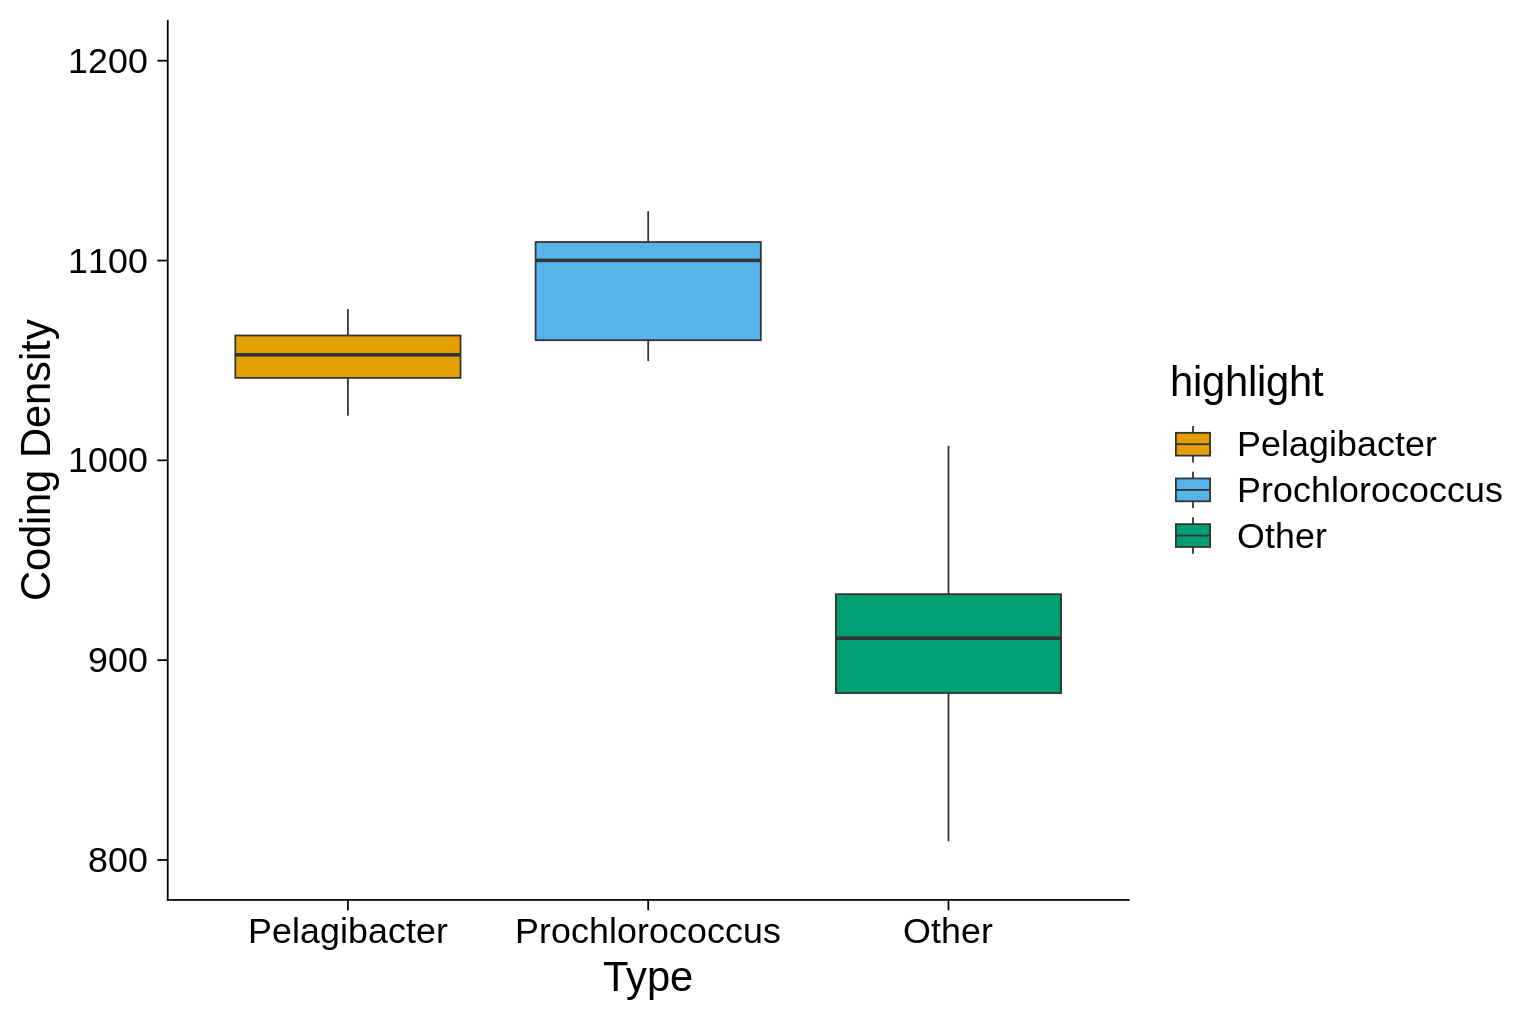

In [86]:
okabe_ito <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#999999")


ggplot(prokaryotes_only, aes(x=highlight, y=coding_density)) +
  geom_boxplot(aes(fill=highlight), outlier.shape = NA) +
  scale_x_discrete(name='Type') +
  scale_y_continuous(name='Coding Density', limits=c(800, 1200)) +
  scale_fill_manual(values=okabe_ito) +
  theme_cowplot(25)

Note the warning on the removal of rows - these are the values that fall outside of this range and it's generally a good idea to report on this if you end up needing to limit your axes in this way. If you can, always use scaling (e.g. square root, log etc) to show all the data across large ranges.

Now one thing this figure hides is that there are so many more data points for other than for Pelagibacter and Prochlorococcus.

It would be great if we could also plot on the actual points. As we saw before, this is easy with `ggplot` because you can plot multiple plots on the same plot.

So here, we are going to plot the box plots, and then plot the actual points using `geom_point`.

Warning message:
“Removed 1853 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1853 rows containing missing values (`geom_point()`).”


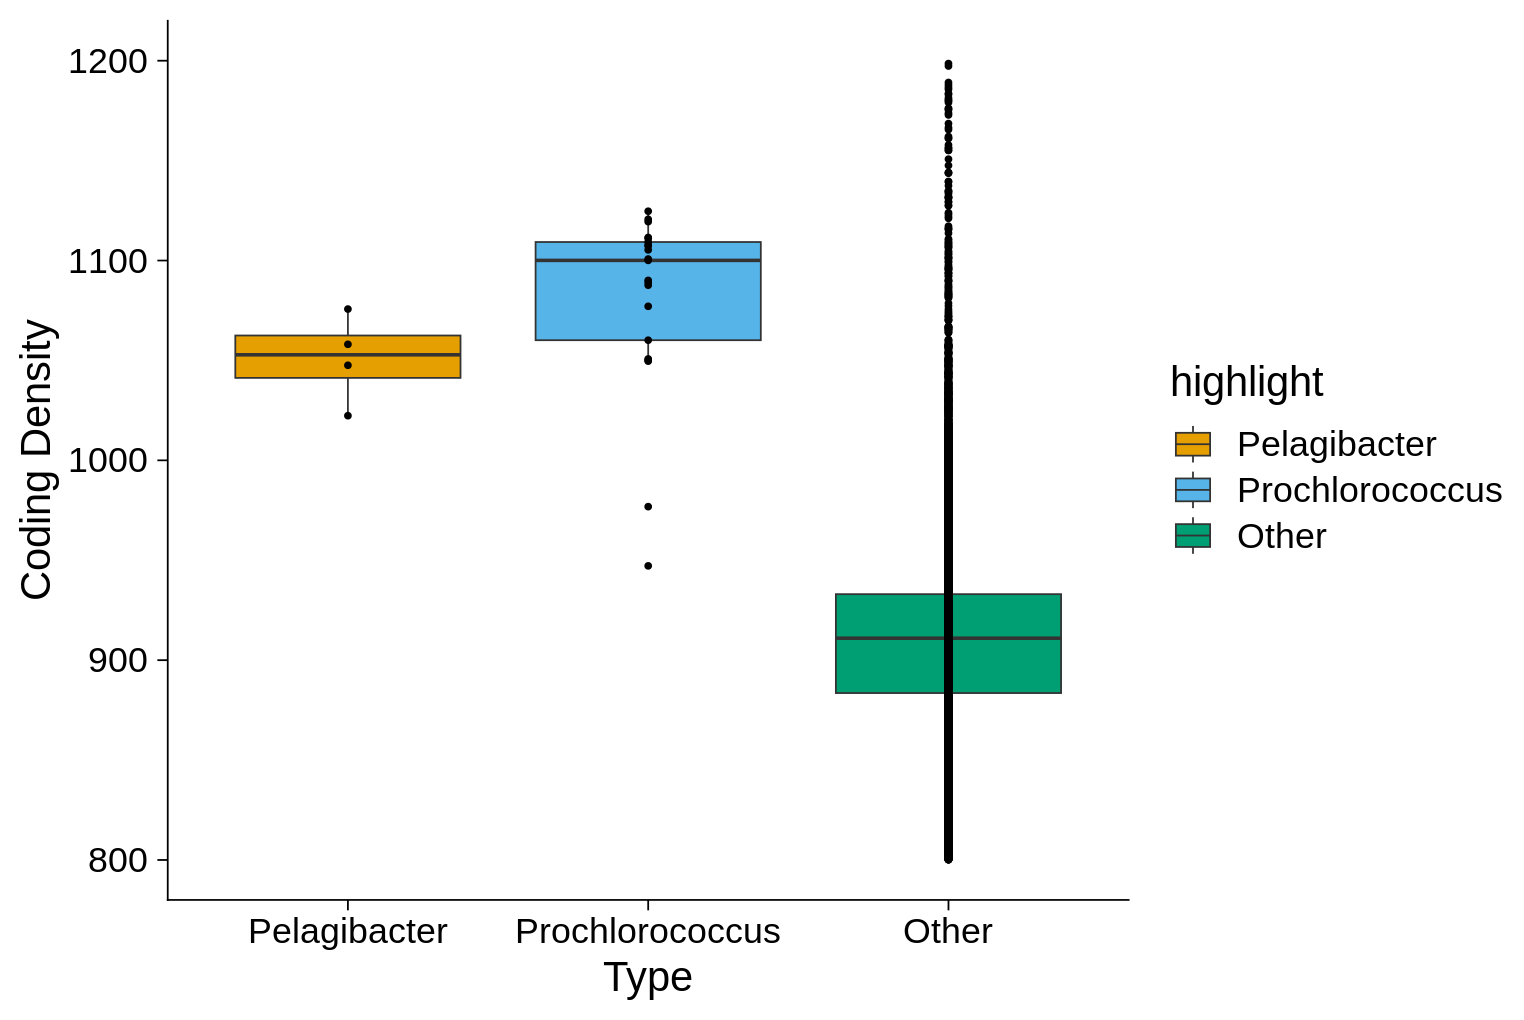

In [87]:
okabe_ito <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#999999")


ggplot(prokaryotes_only, aes(x=highlight, y=coding_density)) +
  geom_boxplot(aes(fill=highlight), outlier.shape = NA) +
  geom_point() +
  scale_x_discrete(name='Type') +
  scale_y_continuous(name='Coding Density', limits=c(800, 1200)) +
  scale_fill_manual(values=okabe_ito) +
  theme_cowplot(25)

Better - now you can see there are thousands of points for `Other` and only a few for `Prochlorococcus` and `Pelagibacter`. We can accentuate this further by adding a jitter function to separate the dots from the central line so they can be seen more clearly.



Warning message:
“Removed 1853 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1853 rows containing missing values (`geom_point()`).”


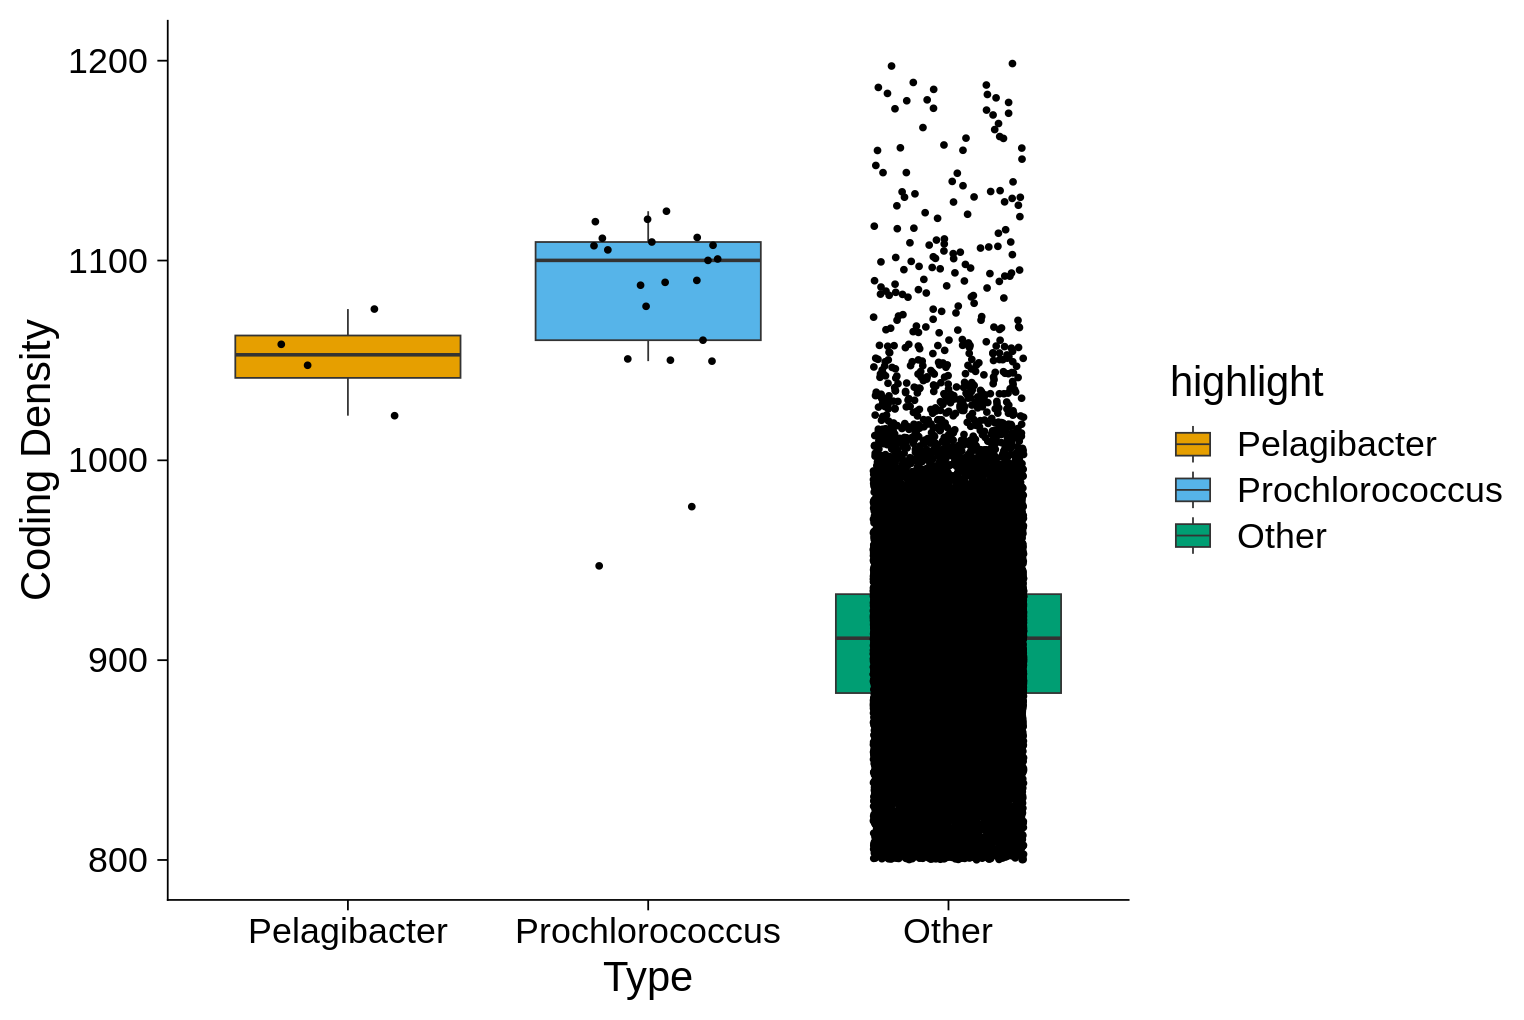

In [88]:
okabe_ito <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#999999")


ggplot(prokaryotes_only, aes(x=highlight, y=coding_density)) +
  geom_boxplot(aes(fill=highlight), outlier.shape = NA) +
  geom_jitter(width = 0.25) +
  scale_x_discrete(name='Type') +
  scale_y_continuous(name='Coding Density', limits=c(800, 1200)) +
  scale_fill_manual(values=okabe_ito) +
  theme_cowplot(25)

Now we can tidy things up a bit by plotting the points first, and then plotting the boxplots over the top, and decreasing the alpha to make them translucent. We can also hide the now-redundant legend

Warning message:
“Removed 1853 rows containing non-finite values (`stat_boxplot()`).”
Warning message:
“Removed 1853 rows containing missing values (`geom_point()`).”


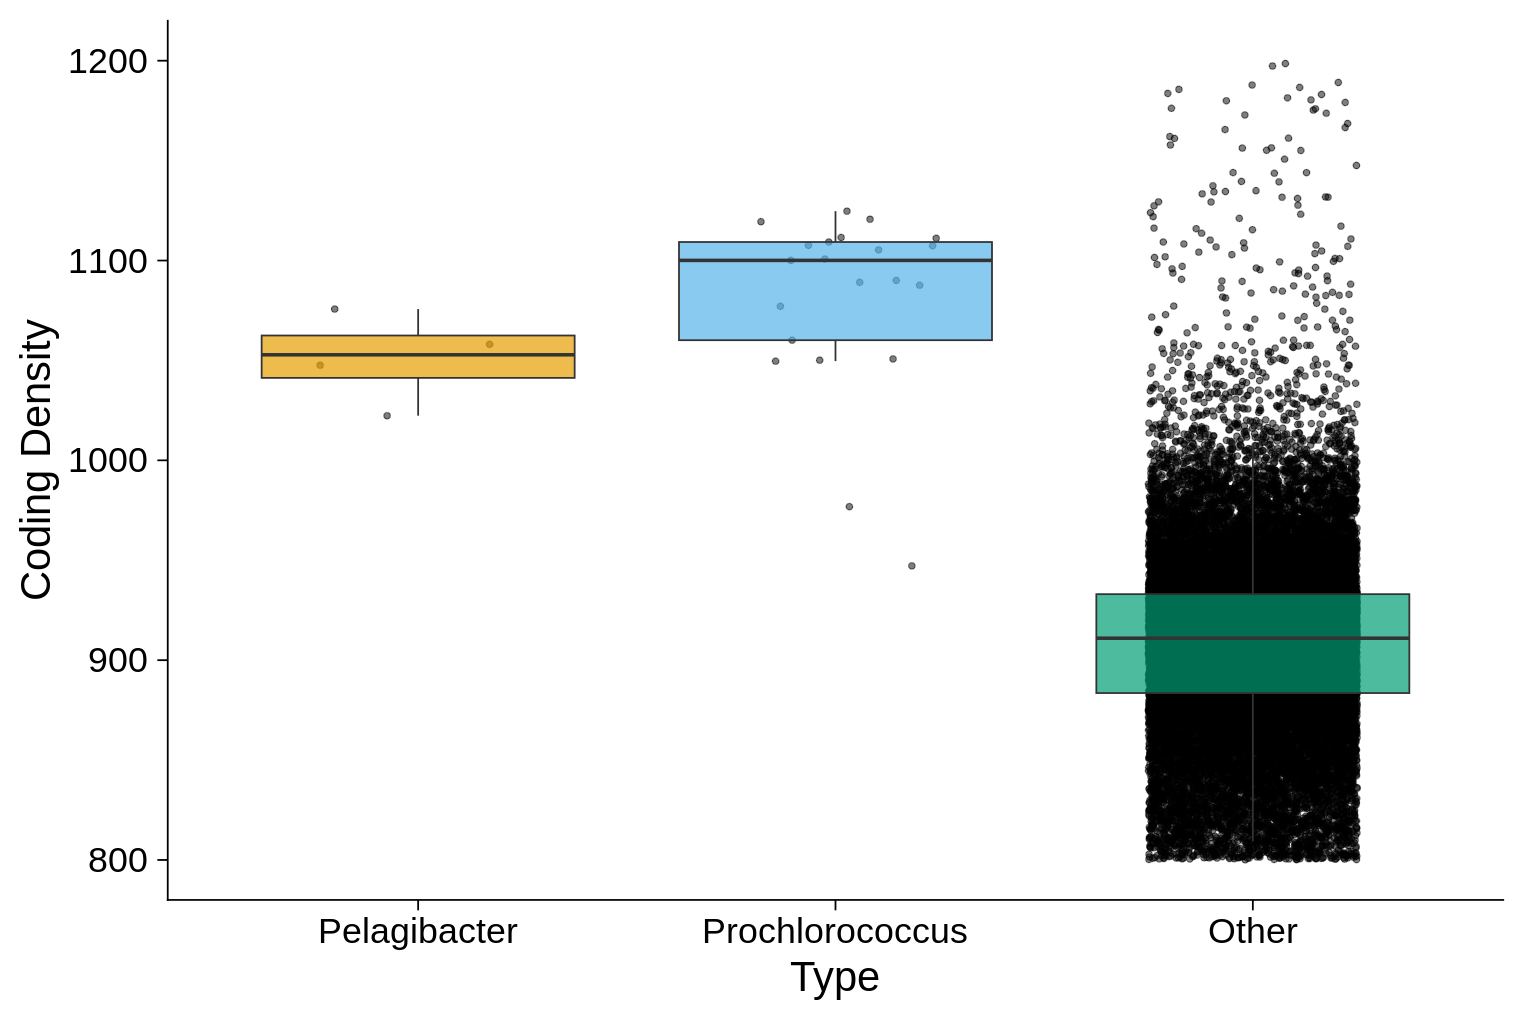

In [92]:
okabe_ito <- c("#E69F00", "#56B4E9", "#009E73", "#F0E442", "#0072B2", "#999999")


ggplot(prokaryotes_only, aes(x=highlight, y=coding_density)) +
  geom_jitter(width = 0.25, alpha=0.5) +
  geom_boxplot(aes(fill=highlight), outlier.shape = NA, alpha=0.7) +
  scale_x_discrete(name='Type') +
  scale_y_continuous(name='Coding Density', limits=c(800, 1200)) +
  scale_fill_manual(values=okabe_ito) +
  theme_cowplot(25) +
  theme(legend.position='none')

You can see in this data that a lot of the data points for `Other` are being cut off as the bottom is very blocky still.

When your data is this skewed in terms of sample size, it is worth considering randomly subsampling the most abundant one